# Spark - Machine Learning Fundamentals
In this courselet, we are going to explore the basics in the use of Spark as a tool to train a Machine Learning model. By the end of this courselet, you should be able to:

- Recognize the fundamentals in training a ML model using Spark
- Identify two different ML algorithms
- Identify the main libraries and documentation to perform your tasks

This courselet presupposes a foundational understanding of fundamental machine learning processes and the Spark framework. It is designed primarily to introduce coding within these contexts, rather than to focus exclusively on the development of rigorously accurate models.

For this courselet, we will use taxi trips reported to the City of Chicago in 2020. This data is publicly available through the [Chicago Data Portal](https://data.cityofchicago.org/en/Transportation/Taxi-Trips-2020/r2u4-wwk3/about_data) If you previously covered the Exploratory Data Analysis with Spark courselet, you should be familiar with this dataset. 

In this courselet, we are going to explore the following cases:

- **Regression:** We are going to try to estimate the fare price of a trip, given a collection of features based on location, temporality, and trip duration.
- **Clustering:** We are going to segmentate our trips in 10 different clusters, using the coordinates and temporality components as our clustering features.

We are using the data in [Parquet format](https://parquet.apache.org/), given the several advantages of this format.

## Module 2: Clustering

As a very first step, we will start by initiating our Spark session.

In [1]:
import pyspark
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("ML-Process-Clustering") \
    .getOrCreate()

In [2]:
# We start by loading the data and printing the schema
df = spark.read.parquet("data/chicago-taxi-2020.parquet",header=True, inferSchema=True)
df.printSchema() 

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: double (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: double (nullable = true)
 |-- Dropoff Census Tract: double (nullable = true)
 |-- Pickup Community Area: double (nullable = true)
 |-- Dropoff Community Area: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid

In [3]:
# A display of the first few rows
df.limit(5).toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,16c7456d99031528c238bd02f40df5ab9bdf9778,88d3be8c1334607f62a8c058f680dd7fbb57826ec7408d...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,60.0,0.00,NaN,NaN,NaN,NaN,...,9.0,12.27,Credit Card,Top Cab Affiliation,NaN,NaN,None,NaN,NaN,None
1,472eef1d5c7a5e5ee033f673942f367dc71869f1,199fa05b63204aa1c620c161c5cebe43b0909b1ee99864...,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1740.0,0.00,NaN,NaN,NaN,43.0,...,0.0,13.00,Cash,Blue Ribbon Taxi Association Inc.,NaN,NaN,None,41.761578,-87.572782,POINT (-87.5727819867 41.7615779081)
2,031a4d882fb3315a490d0b5c358c945ad9b9856d,aabecb47e958f99860a3b4d01f14d53644ac26126d9519...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.70,NaN,NaN,8.0,8.0,...,5.0,14.80,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,3c416c246829dfb3f78cc93cbc7dfecdd379be15,ba106251fbb2b52177138ccbb8a1327a83c89470c240b2...,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,720.0,0.80,NaN,NaN,8.0,8.0,...,2.0,9.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
4,3c0a22971ae070ce35e0c03f1b8e92fe7aa840cd,1f1970d8e52c7e2575aeb68eb3b6ab0e21c77b728267df...,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,556.0,0.77,NaN,NaN,8.0,8.0,...,0.0,6.75,Cash,Sun Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


### Data pre-processing and feature engineering

For our clustering, our data pre-processing will go as follows:

1. We will start by creating a sub-df in which we'll exclusively keep those features that are part of our analysis
2. We will extract the hour and the day of the week from *Trip Start Timestamp*
3. We will encode the hour and day of the week to treat them as categories
4. We will place all of our explanatory features into a vector column using [VectorAssembler](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)l data.

In [4]:
# Select clustering features 
clustering_features = ["Trip Start Timestamp", "Pickup Centroid Latitude", "Pickup Centroid Longitude"]
df_clust = df.select(*clustering_features).dropna(how='any', subset=clustering_features) # We make sure to drop any missing values

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_timestamp, hour, dayofweek

# The following lines represent a similar process as the one we did before for regression
hour_indexer = StringIndexer(inputCol="pickup_hour", 
                             outputCol="pickup_hour_indexed")
day_of_week_indexer = StringIndexer(inputCol="pickup_day_of_week", 
                                    outputCol="pickup_day_of_week_indexed")



hour_encoder = OneHotEncoder(inputCols=["pickup_hour_indexed"], 
                             outputCols=["pickup_hour_vec"])
day_of_week_encoder = OneHotEncoder(inputCols=["pickup_day_of_week_indexed"], 
                                    outputCols=["pickup_day_of_week_vec"])

df_clust =  df_clust.withColumn("Trip Start Timestamp", 
                            to_timestamp("Trip Start Timestamp", 'MM/dd/yyyy hh:mm:ss a')) \
                .withColumn("pickup_hour", hour("Trip Start Timestamp")) \
                .withColumn("pickup_day_of_week", dayofweek("Trip Start Timestamp"))

df_clust = df_clust.withColumn("pickup_hour", df_clust["pickup_hour"].cast("string")) \
               .withColumn("pickup_day_of_week", df_clust["pickup_day_of_week"].cast("string"))

pipeline_clust = Pipeline(stages=[hour_indexer, day_of_week_indexer, 
                            hour_encoder, day_of_week_encoder])

df_clust = pipeline_clust.fit(df_clust).transform(df_clust)

In [6]:
clust_input_cols = ["pickup_hour_vec", "pickup_day_of_week_vec", "Pickup Centroid Latitude", "Pickup Centroid Longitude"]
clust_assembler = VectorAssembler(inputCols=clust_input_cols, outputCol="features")
df_clust = clust_assembler.transform(df_clust)

## Training

Now we will try to find the optimal number of clusters given our features. We are going to use the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Applying the K-Means algorithm, we are going to train for different values of K. Then, for each model we will calculate the [Within-Sum of Squares Error](https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/multivariate/how-to/cluster-k-means/interpret-the-results/all-statistics-and-graphs/#within-cluster-sum-of-squares). Finally, we will plot all of our WSSE's and heuristically determine our optimal number of clusters.

To achieve our purpose, we will define a series of helper functions.

In [7]:
from pyspark.ml.clustering import KMeans as KM
import pandas as pd
from pyspark.mllib.linalg import DenseVector
from pyspark.sql import Row
from math import sqrt
from numpy import array


def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    
    def extract_features_and_prediction(row):
        features_array = array(row.features.toArray()).tolist()
        return Row(features=features_array, prediction=row.prediction)
    
    arrayCollection = featuresAndPrediction.rdd.map(lambda row: extract_features_and_prediction(row))

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

In [8]:
# Calculating WSSE for clusters K=2 to K=14
clusters = range(2,15)
wsseList = elbow(df_clust,clusters)

Training for cluster size 2 
......................WSSE = 4461429.3085504165 
Training for cluster size 3 
......................WSSE = 4211254.570287933 
Training for cluster size 4 
......................WSSE = 3974271.151749854 
Training for cluster size 5 
......................WSSE = 3838842.938951451 
Training for cluster size 6 
......................WSSE = 3789559.7495426163 
Training for cluster size 7 
......................WSSE = 3504729.4140079315 
Training for cluster size 8 
......................WSSE = 3478518.547733676 
Training for cluster size 9 
......................WSSE = 3462879.450145512 
Training for cluster size 10 
......................WSSE = 3418703.139289174 
Training for cluster size 11 
......................WSSE = 3418064.0750562525 
Training for cluster size 12 
......................WSSE = 3450136.3547196863 
Training for cluster size 13 
......................WSSE = 3492757.3379418356 
Training for cluster size 14 
......................WSSE = 3360311

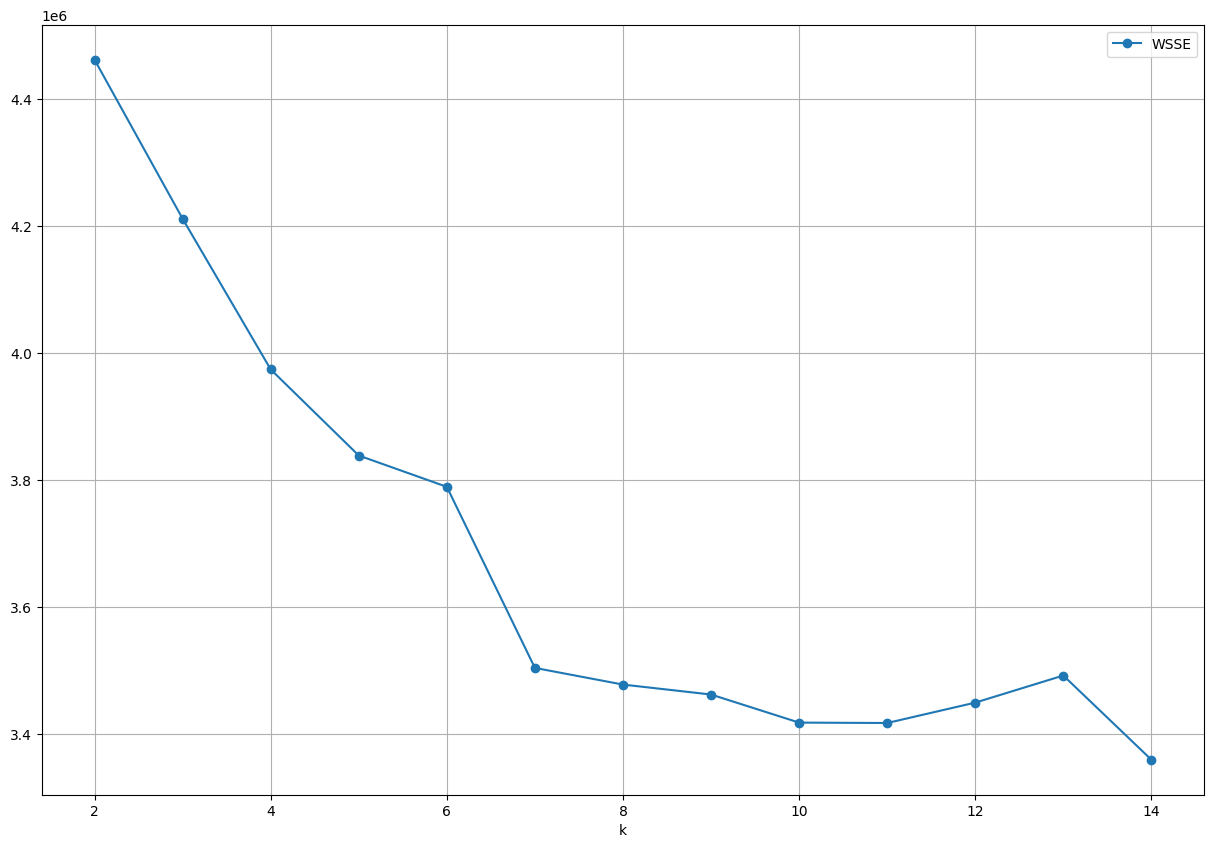

In [9]:
# Plotting our elbow
elbow_plot(wsseList,clusters)

Looking at the plot, the optimal number of clusters seems to be 7.

### Explore More

The extensive collection of algorithms, framweworks and utilities that PySpark offers for Machine Learning tasks can be found in the following links:

- [MLlib (DataFrame-based)](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html)
- [MLlib (RDD-based)](https://spark.apache.org/docs/latest/api/python/reference/pyspark.mllib.html)